## Fourier Transforms

**Prof. Geoffrey Hutchison, University of Pittsburgh**

### Objectives

By the end of this notebook, you should be able to:

- Understand how to use Fourier transform to shift from time-domain data to frequency domain signals
  - e.g. FTIR, FT NMR, FT UV/Vis.. (pretty much all spectroscopy)
- Understand other related transforms (e.g. Wavelet)

Keywords: #FourierTransforms, #Math #Scipy

In [14]:
import numpy as np
import matplotlib.pyplot as plt

### Fourier Transform

We've talked about using the Fourier series as a sum of sine and cosine functions - we find the coefficients using overlap integrals.

We can remember that the Euler transform converts $e^{ix}$ into sine and cosines, so we can also write the Fourier series in complex numbers:

$$
f(x)=\sum_{n=0}^{\infty} c_{n} \exp \left(i \frac{2 \pi n x}{L}\right)
$$

And the coefficients would then be:

$$
c_{n}=\frac{1}{L} \int_{-\frac{L}{2}}^{\frac{L}{2}} f(x) \exp \left(-i \frac{2 \pi n x}{L}\right) d x
$$

We might not like the use of complex numbers, but it's obviously the same Fourier series.

We can also simplify the notation a bit, by introducing the "wave number"

$$
k_{n}=\frac{2 \pi n}{L} = \frac{2 \pi}{\lambda}
$$

where $\lambda$ is the wavelength.

If we let the length $L$ go to infinity, then:

$$
\Delta k_{n}=\frac{2 \pi n}{L} \rightarrow d k
$$

the coefficients are:

$$
c(k)=\frac{1}{2 \pi} \int_{-\infty}^{\infty} f(x) \mathrm{e}^{-i k x} d x
$$

<div class="alert alert-block alert-success">
    
This is the **Fourier transform**:

$$
F(k)=\int_{-\infty}^{\infty} f(x) \mathrm{e}^{-i k x} d x
$$

Then the original $f(x)$ is the **inverse Fourier transform**:

$$
f(x)=\frac{1}{2 \pi} \int_{-\infty}^{\infty} F(k) \mathrm{e}^{i k x} d k
$$
    
</div>

Let's see a few examples...

We're going to construct an array of time points.

Then we'll set up a function with two sine waves:

$$
y = \sin(30 \cdot 2\pi t) + \frac{1}{2} \sin(50 \cdot 2 \pi t)
$$

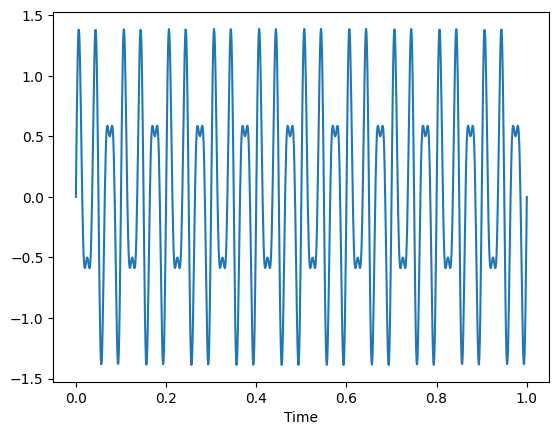

In [15]:
# Number of sample points
N = 1000
# sample spacing
delta = 1.0 / 1000.0

t = np.linspace(0.0, delta*N, N)
y = np.sin(30.0 * 2.0*np.pi*t) + 0.5*np.sin(50.0 * 2.0*np.pi*t)

plt.plot(t, y)

plt.xlabel("Time")
plt.show()

Seems suitably complicated.

We can use `scipy.fftpack` to perform the "fast Fourier transform" (FFT). The resulting "x" variable will be in frequency - so the limit is defined by the $dt$ we had. We cannot find a higher frequency than that time resolution. (In short, if we expected to have GHz signals, we'd need short time resolution.)

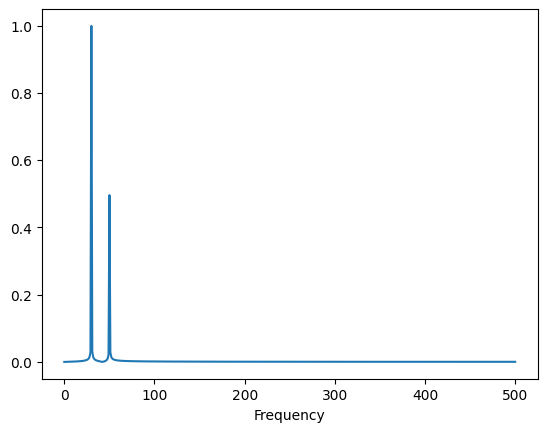

In [16]:
import scipy.fftpack

xf = np.linspace(0.0, 1.0/(2.0*delta), (N//2))
yf = scipy.fftpack.fft(y)

plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.xlabel("Frequency")
plt.show()

Notice it's not a *perfect* reconstruction. We only put in two specific frequencies, so we'd expect to see two different lines. But if we don't have exactly perfect waves when we cut off the time signal, there will be a bit of peak width.

The time-domain signal can be as complicated as we want. Here's an example with 4 frequencies - note that it doesn't matter the *phase* indicated by sine or cosine functions - they're both periodic.

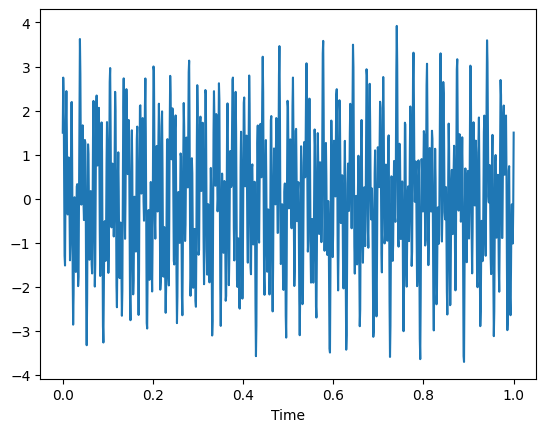

In [17]:
y = np.sin(30.0 *2.0*np.pi*t) + 0.5*np.cos(50.0 *2.0*np.pi*t)
y = y + 1.5*np.sin(165.0 *2.0*np.pi*t) + np.cos(104 * 2*np.pi*t)

plt.plot(t, y)

plt.xlabel("Time")
plt.show()

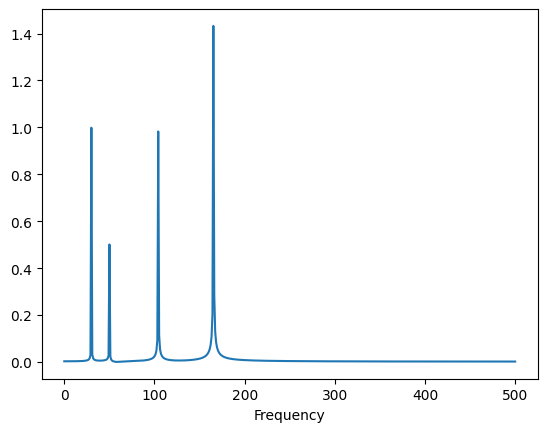

In [18]:
yf = scipy.fftpack.fft(y)

plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.xlabel("Frequency")
plt.show()

Whatever signals we put into our time function will come out from our FFT .. at least given the time resolution we start with. (We can't find 800 Hz frequencies in this example).

Also, the time signal doesn't need to be completely periodic.. a "chirp" can also work where the signal intensity drops over time.

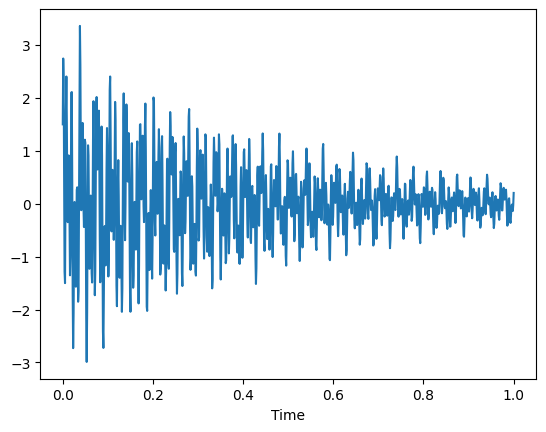

In [19]:
y = y * np.exp(-2*t)

plt.plot(t, y)

plt.xlabel("Time")
plt.show()

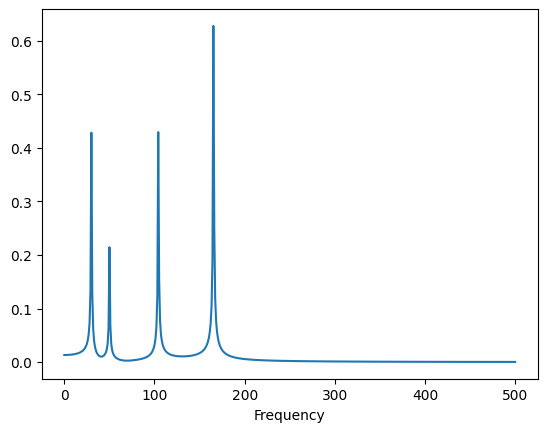

In [20]:
yf = scipy.fftpack.fft(y)

plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.xlabel("Frequency")
plt.show()

Notice that while the peak heights changed a bit, the relative intensities and peak areas remain unchanged. So if you're doing spectroscopy, you'll need a few wave repeats, but it doesn't need to be a "continuous wave" spectra - useful if you're worried about applying a high-intensity beam (e.g. x-ray, etc.)

Let's try the FFT on our square wave from last time.

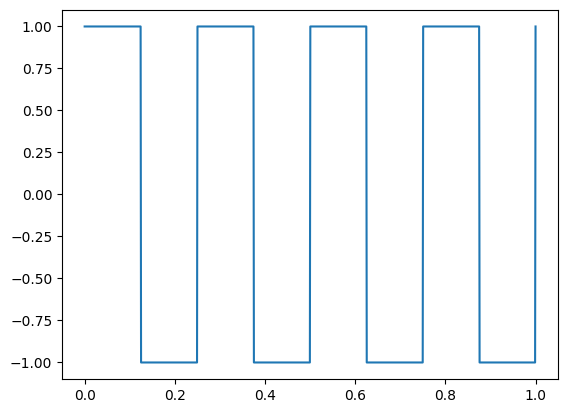

In [21]:
import scipy.signal

y = scipy.signal.square(4 * np.pi * 2 * t)

plt.plot(t, y)
plt.show()

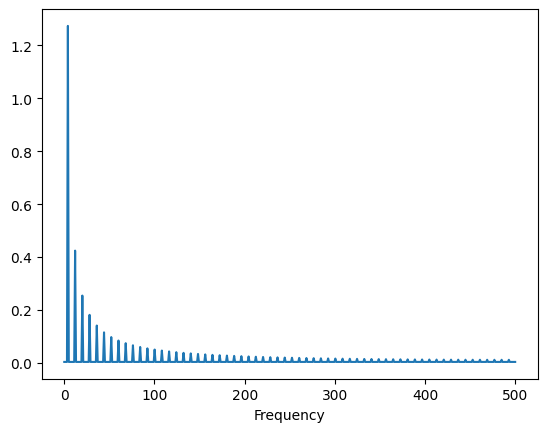

In [22]:
yf = scipy.fftpack.fft(y)

plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.xlabel("Frequency")
plt.show()

You can see the "ringing" - basically all the frequencies show up at least a bit to try to get those sharp corners.

We can also use the inverse FFT `scipy.fft.ifft()` to go back to the time domain. In this case, the differences are minor.

/Users/agco-kun/.virtualenvs/kzspace-ePujzJDD/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


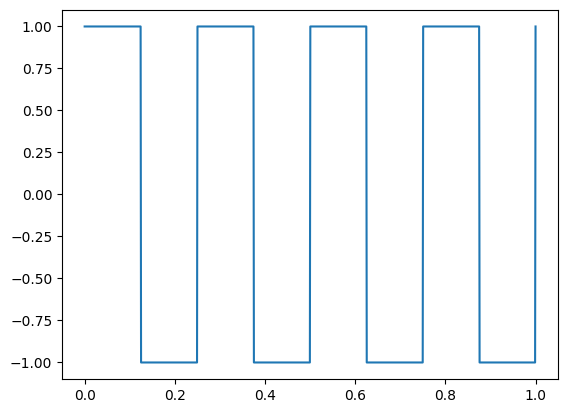

In [23]:
inverse = scipy.fft.ifft(yf)

plt.plot(t, inverse)
plt.show()

### Fourier Transform for Audio

Unfortunately, it turns out to be a bit tricky to do Fourier transform on raw NMR data. For one, some instrument manufacturers add "fingerprints" for unclear reasons. For another, we usually plot NMR in ppm, not in frequency (e.g. MHz).

So we'll look at some slightly more complicated examples using audio files.

In [24]:
import scipy
import scipy.io.wavfile

# Graphing helper function
def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

Here's a recording of me saying the "ah" sound.

In [25]:
# NOTE: This is only works with 1 channel (mono).  To record a mono audio sample,
# you can use this command: rec -r 44100 -c 1 -b 16 test.wav
(sample_rate, input_signal) = scipy.io.wavfile.read("audio/ah.wav")
time_array = np.arange(0, len(input_signal)/sample_rate, 1/sample_rate)

FileNotFoundError: [Errno 2] No such file or directory: 'audio/ah.wav'

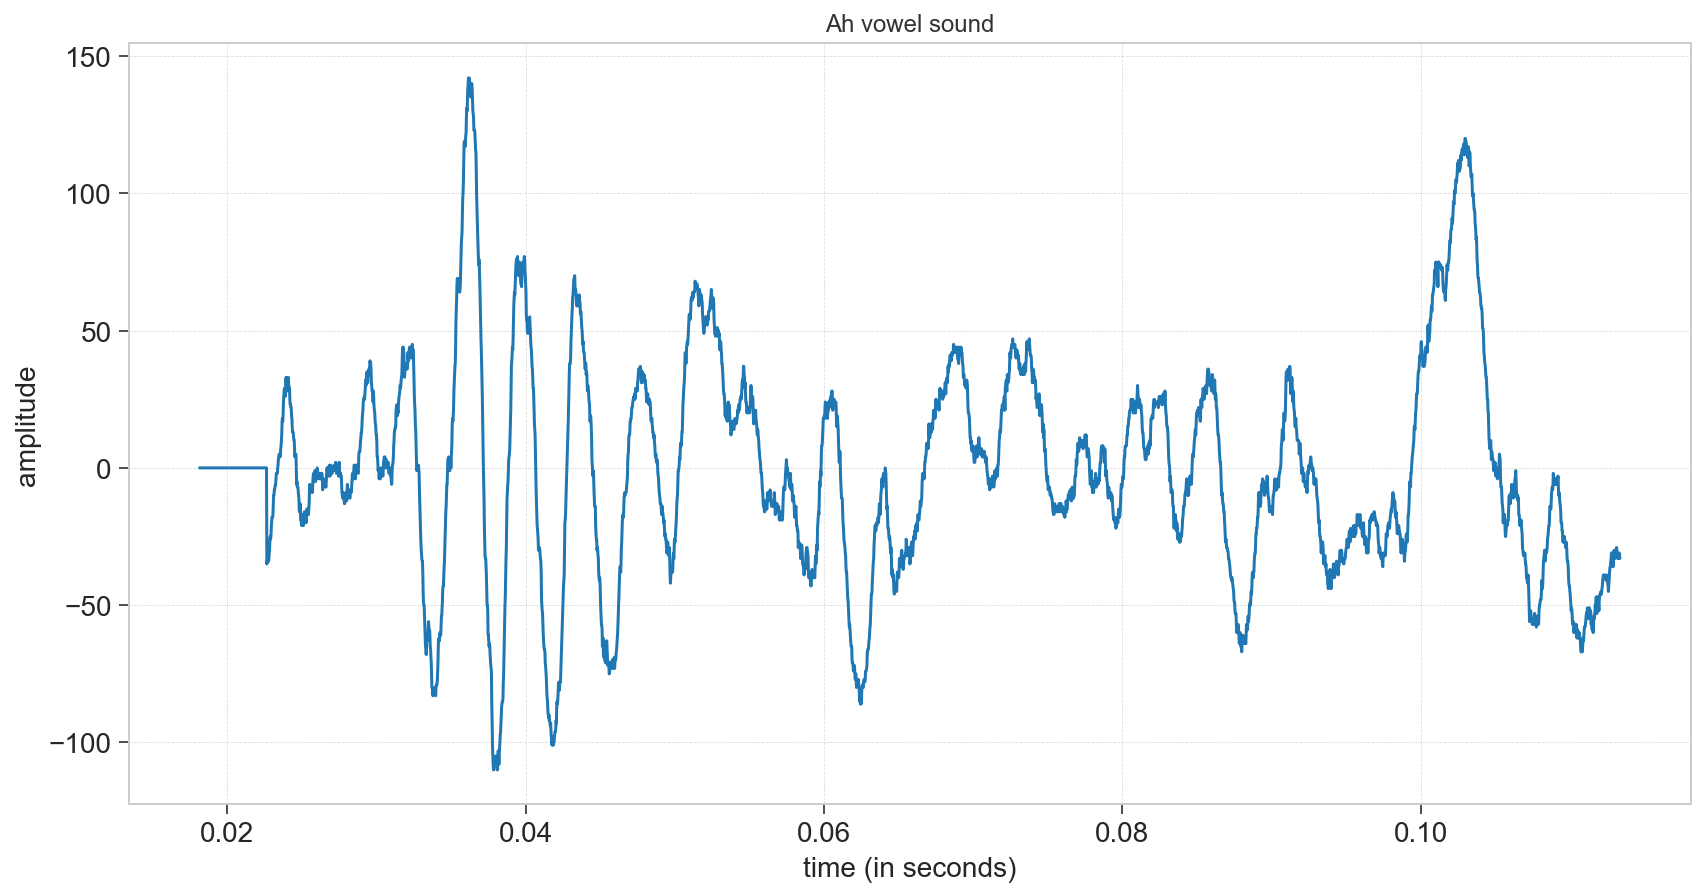

In [ ]:
setup_graph(title='Ah vowel sound', x_label='time (in seconds)', y_label='amplitude', fig_size=(14,7))
_ = plt.plot(time_array[800:5000], input_signal[800:5000])

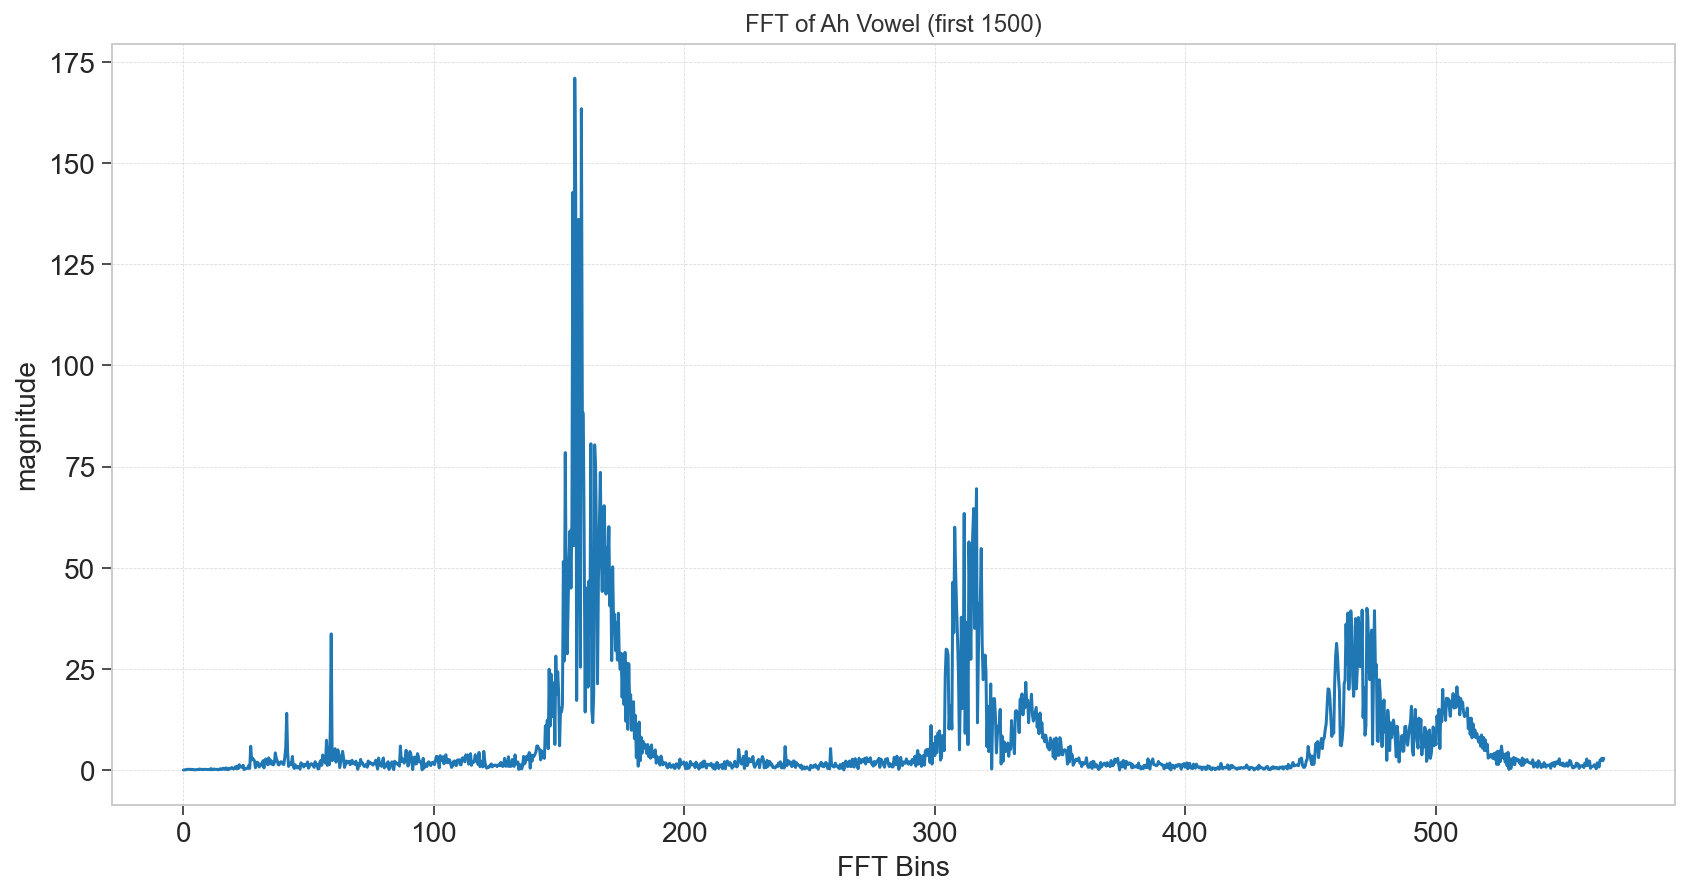

In [ ]:
fft_out = np.fft.rfft(input_signal)
fft_mag = [np.sqrt(i.real**2 + i.imag**2)/len(fft_out) for i in fft_out]
num_samples = len(input_signal)
rfreqs = [(i*1.0/num_samples)*sample_rate for i in range(num_samples//2+1)]

setup_graph(title='FFT of Ah Vowel (first 1500)', x_label='FFT Bins', y_label='magnitude', fig_size=(14,7))
_ = plt.plot(rfreqs[0:1500], fft_mag[0:1500])

In short, the FFT enables us to get frequency spectra out of a time signal. Hit a sample, get it to "sing" and you'll find out all the frequencies in one shot. (You can repeat if you want to average and improve the signal to noise.. remember standard error.)

What about getting frequencies as a function of time?

That's called a spectrogram.

Here's a short scale "do re mi fa sol .."

In [ ]:
(doremi_sample_rate, doremi) = scipy.io.wavfile.read("audio/do-re-mi.wav")

/opt/local/mambaforge/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


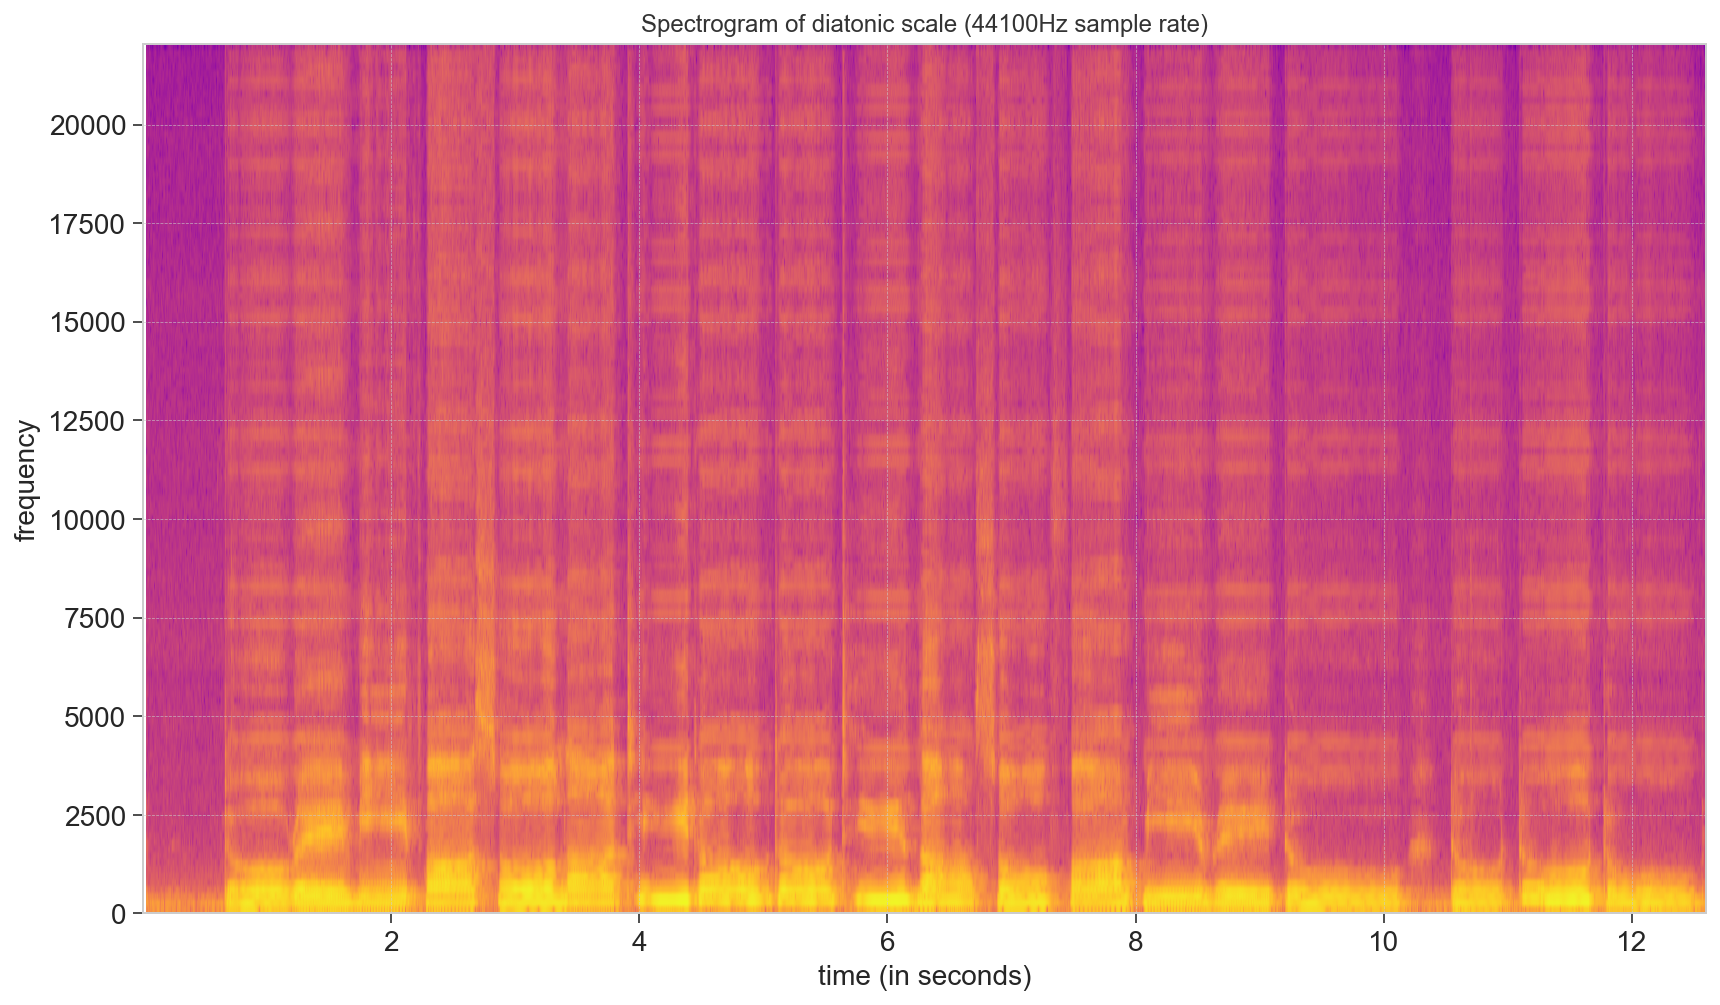

In [ ]:
setup_graph(title='Spectrogram of diatonic scale (44100Hz sample rate)', x_label='time (in seconds)', y_label='frequency', fig_size=(14,8))
_ = plt.specgram(doremi, Fs=doremi_sample_rate, cmap='plasma')

There's a lot of data up there in the higher regions (overtones) but that's not really where I'm singing.

Let's look at the lower frequency data - zero to 4000 Hz..

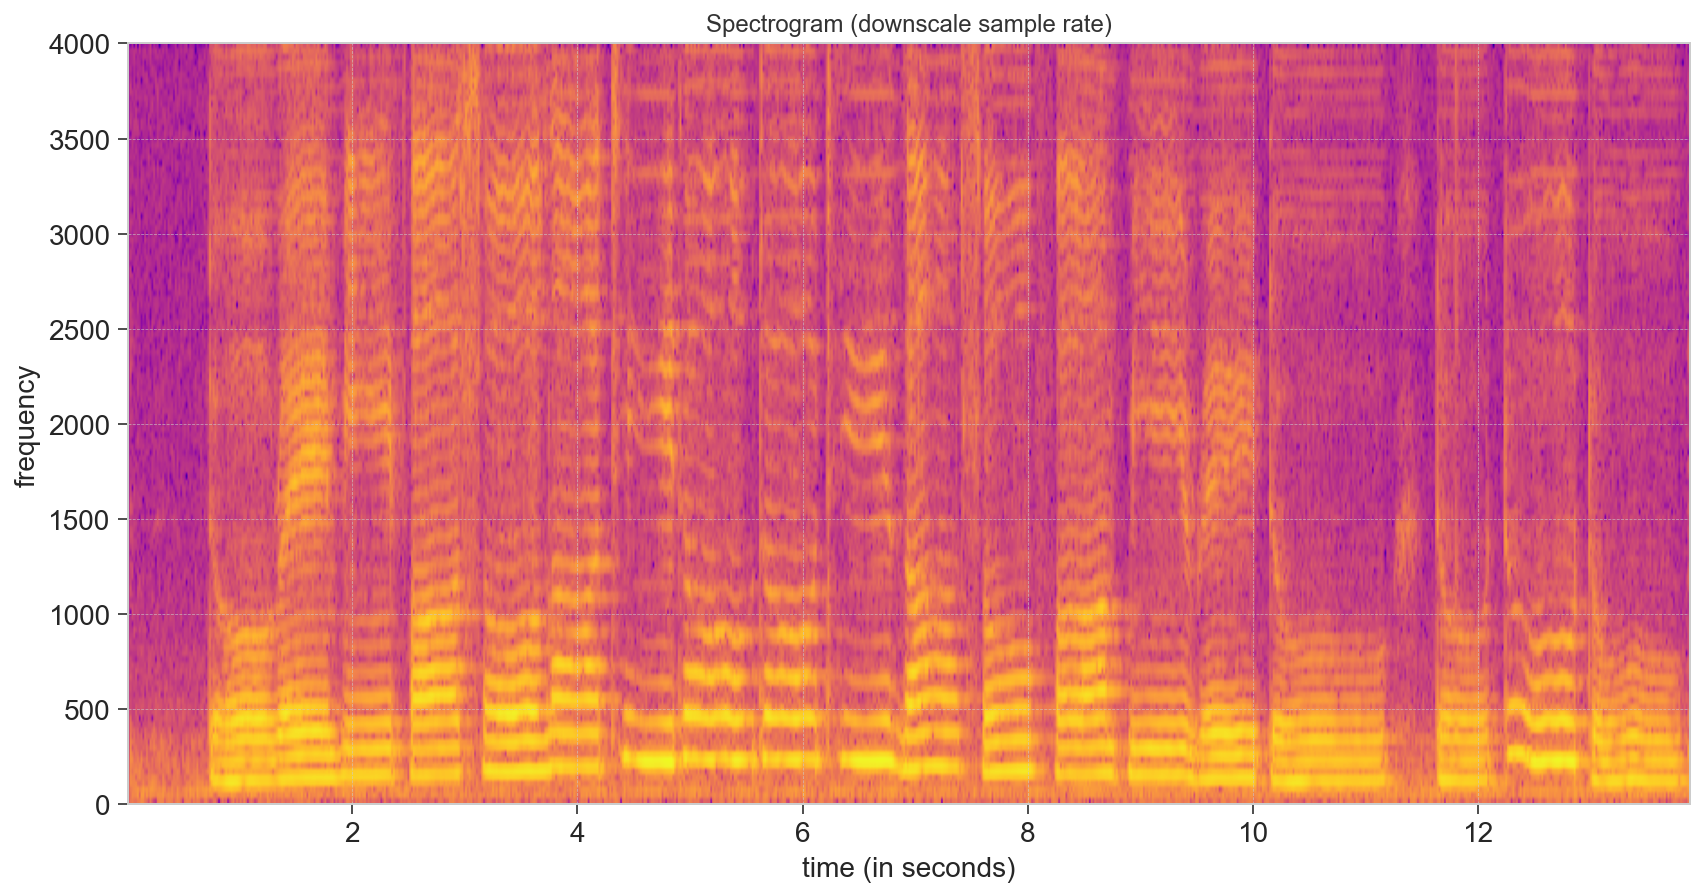

In [ ]:
downscale = 8000

doremi_downscale = [doremi[i] for i in range(0, len(doremi), 44100//downscale)]
setup_graph(title='Spectrogram (downscale sample rate)', x_label='time (in seconds)', y_label='frequency', fig_size=(14,7))
_ = plt.specgram(doremi_downscale, Fs=downscale, cmap='plasma')

Not only can we see the increasing frequency in the scale, but it's possible to see overtones at $2\times$, $3\times$, and higher frequencies. This is one thing that separates natural sounds from some artificial sounds (buzzers and the like).

In [ ]:
# we should delete the data to free up some memory on the server
del(doremi, doremi_downscale)

### Other Transforms

There are a huge variety of other transforms. The main idea is to map a complicated function into:
- a set of coefficients 
- a set of simpler basis functions

(One chemical example is converting molecular orbitals into sums of hydrogen-like atomic orbitals.)

Fourier transforms are useful because, once in the frequency domain, you can remove selected noise (e.g., low-frequency such as building movement, footsteps, etc., or high-frequency like electrical noise, etc.)

On the other hand, since Fourier transforms require periodic (or mostly periodic signals) there are alternatives:
- [Wavelets](https://en.wikipedia.org/wiki/Wavelet) have frequencies but are designed to have finite length (so you know *when* the signal occurred)

<a href="https://commons.wikimedia.org/wiki/File:MorletWaveletMathematica.svg#/media/File:MorletWaveletMathematica.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/MorletWaveletMathematica.svg/1200px-MorletWaveletMathematica.svg.png" alt="MorletWaveletMathematica.svg" width="350" /></a>

- [Discrete Cosine](https://en.wikipedia.org/wiki/Discrete_cosine_transform) used heavily in audio and video compression (JPEG, MP3, H.264, etc.) - similar to a Fourier series, but only the cosine terms

- Discrete Sine - only the sine terms from a Fourier series

- [Laplace Transform](https://en.wikipedia.org/wiki/Laplace_transform) - turns a function of time into a function of complex frequency - useful in image / audio / signal processing - but also in solving differential equations, since differentiation becomes multiplication, and integration becomes division.